## imports

In [1]:
import torchfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from imageio import imread
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, sampler
from skimage.transform import pyramid_gaussian

In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## training functions

In [3]:
def evaluate_loss(model, data, labels, loss_fn):
    """
    evaluate the loss
    """
    predicted = model(data)
    errors = loss_fn(predicted, labels)
    return float(errors)


def plot_loss(train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.show()
  
def save_plot(name, train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.savefig(name)

def train(model, epochs, loader, loss_fn, optimizer, scheduler, X_val, Y_val, print_every=10):
    train_loss = []
    val_loss = []
    train_loss.append(evaluate_loss(model, loader.dataset.tensors[0], loader.dataset.tensors[1], loss_fn))
    val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
    for e in range(1,epochs + 1):
        batches_loss = []
        for t, (x, y) in enumerate(loader):
            scheduler.step()
            model.train()
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = model(x)
            # Calculate Loss
            loss = loss_fn(y_pred, y)
            # optimization
            optimizer.zero_grad()
            # backward propagation
            loss.backward()
            # Updating parameters
            optimizer.step()
            batches_loss.append(loss.item())
        if e % print_every == 0:
            print(f'ephoc {e}, loss = {np.mean(np.array(batches_loss)):.4f}  val_loss = {evaluate_loss(model, X_val, Y_val, loss_fn):.4f}')
            
        train_loss.append(np.mean(np.array(batches_loss)))
        val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
        
    return train_loss, val_loss


import torch.nn as nn
class View(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

## data loading

In [65]:
C = 3
L = 12
W = 12
output_dim = 2

In [66]:
data_dict = torchfile.load('./EX2_data/aflw/aflw_12.t7')

In [67]:
data = []
for key in data_dict:
    data.append(data_dict[key])
data = np.stack(data)

In [68]:
data.shape

(24385, 3, 12, 12)

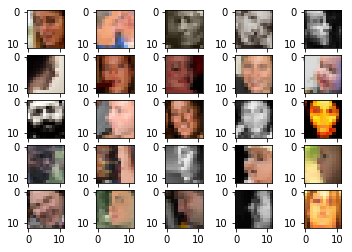

In [69]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, data.shape[0], 25)):
    ax.imshow(np.moveaxis(data[idx], 0, 2))

In [70]:
person_images_df = pd.read_csv('./EX2_data/VOCdevkit/VOC2007/ImageSets/Main/person_trainval.txt', sep = '\s+', header=None,  dtype={0: str})

In [71]:
person_images_df = person_images_df[person_images_df[1] == -1]

In [72]:
person_images_df.shape

(2916, 2)

In [73]:
num_crop = 30
false_imgs = []
for img_num in person_images_df[0]:
    img = imread('./EX2_data/VOCdevkit/VOC2007/JPEGImages/%s.jpg' %img_num)
    for i, j in zip(np.random.randint(0, img.shape[0] - L, num_crop),
                    np.random.randint(0, img.shape[1] - W, num_crop)):
        crop_img = img[i:i+L, j:j+W, :].copy().astype(np.float)
        false_imgs.append(crop_img / 255)
false_imgs = np.moveaxis(np.stack(false_imgs), 3, 1)

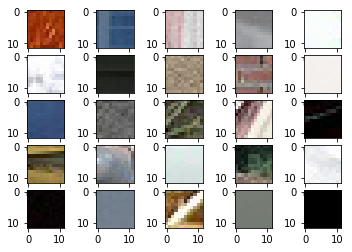

In [74]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, false_imgs.shape[0], 25)):
    ax.imshow(np.moveaxis(false_imgs[idx], 0, 2))

In [75]:
X = np.concatenate((data, false_imgs))
Y = np.concatenate((np.ones(data.shape[0]), np.zeros(false_imgs.shape[0])))
X.shape, Y.shape

((111865, 3, 12, 12), (111865,))

## **Q1**

In [76]:
conv_12_dim = 16
conv_12_size = 3
conv_12_stride = 1
conv_12_pad = 1
max_pool_size = 3
max_pool_stride = 2
max_pool_pad=1
fc_12_size = 16

val_precenteg = 0.15
BATCH_SIZE = 128
print_every = 10

In [77]:
tw_net = nn.Sequential(nn.Conv2d(C, conv_12_dim, conv_12_size, padding=conv_12_pad),
                           nn.MaxPool2d(kernel_size=max_pool_size, stride=max_pool_stride, padding=max_pool_pad),
                           nn.ReLU(),
                           View(),
                           nn.Linear((L // 2) ** 2 * conv_12_dim, fc_12_size),
                           nn.ReLU(),
                           nn.Linear(fc_12_size, output_dim)).to(device=device)

In [78]:
mask = np.arange(0, X.shape[0])
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * val_precenteg)]
train_mask = mask[int(X.shape[0] * val_precenteg):]

X_val = torch.FloatTensor(X[val_mask]).to(device=device)
X_train = torch.FloatTensor(X[train_mask]).to(device=device)
Y_val = torch.LongTensor(Y[val_mask]).to(device=device)
Y_train = torch.LongTensor(Y[train_mask]).to(device=device)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [79]:
conv_train_loss_lst, conv_val_loss_lst = [], []

loss_fn = F.cross_entropy

optimizer = optim.Adam(tw_net.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1.0)

In [80]:
loss = train(tw_net, 30, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)

ephoc 10, loss = 0.0389  val_loss = 0.0385
ephoc 20, loss = 0.0299  val_loss = 0.0496
ephoc 30, loss = 0.0260  val_loss = 0.0322


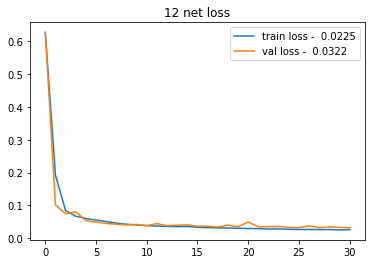

In [87]:
plt.plot(np.arange(len(loss[0])), loss[0], label=f'train loss - {evaluate_loss(tw_net, X_train, Y_train, loss_fn): .4f}')
plt.plot(np.arange(len(loss[1])), loss[1], label=f'val loss - {evaluate_loss(tw_net, X_val, Y_val, loss_fn): .4f}')
plt.legend()
plt.title('12 net loss')
plt.savefig('./tw_net_loss.png')
plt.show()


In [82]:
y_pred = torch.argmax(tw_net(X_val), 1)
acuarcy = torch.sum(y_pred == Y_val).item() / y_pred.shape[0]
train_pred = torch.argmax(tw_net(X_train), 1)
train_acuarcy = torch.sum(train_pred == Y_train).item() / train_pred.shape[0]
print('train acuarcy: %f, val acuarcy: %f' %(train_acuarcy, acuarcy))

mask = np.arange(X_val.shape[0])
np.random.shuffle(mask)
display = X_val[mask[:25]]
y_pred = y_pred[mask[:25]]

train acuarcy: 0.992039, val acuarcy: 0.988617


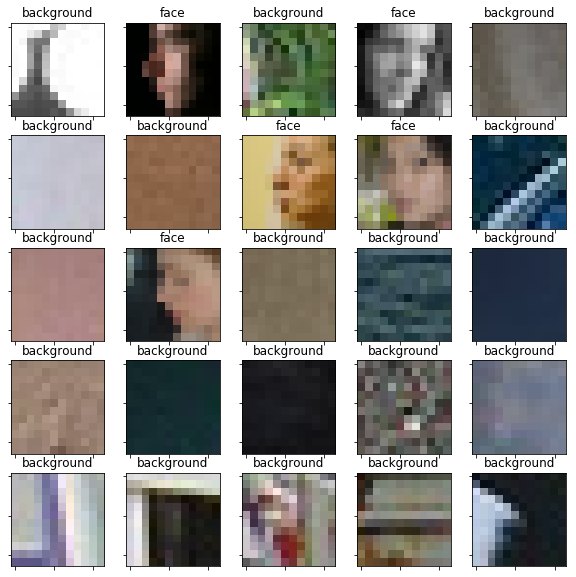

In [83]:
display = display.numpy()
y_pred = y_pred.numpy()
fig, axarr = plt.subplots(5, 5, figsize=(10,10))
for ax, idx in zip(axarr.flatten(), np.arange(25)):
    ax.imshow(np.moveaxis(display[idx], 0, 2))
    if y_pred[idx] == 0:
        title = 'background'
    else:
        title = 'face'
    ax.set_title(title)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

## **Q2**

In [88]:
tw_net_fcn = nn.Sequential(nn.Conv2d(C, conv_12_dim, conv_12_size, padding=conv_12_pad),
                           nn.ZeroPad2d((0, 1, 0, 1)),
                           nn.MaxPool2d(kernel_size=max_pool_size, stride=max_pool_stride),
                           nn.ReLU(),
                           nn.Conv2d(in_channels=conv_12_dim, out_channels=fc_12_size, kernel_size=(L // 2)),
                           nn.ReLU(),
                           nn.Conv2d(in_channels=fc_12_size, out_channels=output_dim, kernel_size=1),
                           )

In [89]:
mask = np.arange(0, X.shape[0])
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * val_precenteg)]
train_mask = mask[int(X.shape[0] * val_precenteg):]

X_val = torch.FloatTensor(X[val_mask]).to(device=device)
X_train = torch.FloatTensor(X[train_mask]).to(device=device)
Y_val = torch.LongTensor(Y[val_mask]).to(device=device).view(-1, 1, 1)
Y_train = torch.LongTensor(Y[train_mask]).to(device=device).view(-1, 1, 1)

train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [90]:
conv_train_loss_lst, conv_val_loss_lst = [], []

loss_fn = F.cross_entropy

optimizer = optim.Adam(tw_net_fcn.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1.0)

In [91]:
loss = train(tw_net_fcn, 30, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)

ephoc 10, loss = 0.0413  val_loss = 0.0410
ephoc 20, loss = 0.0352  val_loss = 0.0677
ephoc 30, loss = 0.0287  val_loss = 0.0341


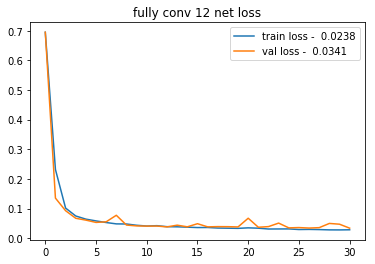

In [92]:
plt.plot(np.arange(len(loss[0])), loss[0], label=f'train loss - {evaluate_loss(tw_net_fcn, X_train, Y_train, loss_fn): .4f}')
plt.plot(np.arange(len(loss[1])), loss[1], label=f'val loss - {evaluate_loss(tw_net_fcn, X_val, Y_val, loss_fn): .4f}')
plt.legend()
plt.title('fully conv 12 net loss')
plt.savefig('./tw_net_fcn_loss.png')
plt.show()

In [95]:
y_pred = torch.argmax(tw_net_fcn(X_val), 1)
acuarcy = torch.sum(y_pred == Y_val).item() / y_pred.shape[0]
train_pred = torch.argmax(tw_net_fcn(X_train), 1)
train_acuarcy = torch.sum(train_pred == Y_train).item() / train_pred.shape[0]
print('train acuarcy: %f, val acuarcy: %f' %(train_acuarcy, acuarcy))

train acuarcy: 0.991313, val acuarcy: 0.987484


In [96]:
home_dir = './EX2_data/fddb/'
with open(home_dir + 'FDDB-folds/FDDB-fold-01.txt') as f:
    paths = f.readlines()
imgs = []
for path in paths:
    img = imread(home_dir + 'images/' + path[:-1] + '.jpg')
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img.astype(np.float64) / 255
    imgs.append(np.moveaxis(img, 2, 0))

In [97]:
imgs[3].shape

(3, 450, 370)

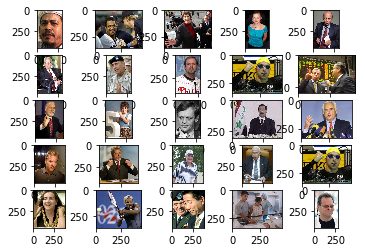

In [98]:
fig, axarr = plt.subplots(5, 5)
for ax, idx in zip(axarr.flatten(), np.random.randint(0, len(imgs), 25)):
    ax.imshow(np.moveaxis(imgs[idx], 0, 2))

In [99]:
tw_net_fcn.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ZeroPad2d(padding=(0, 1, 0, 1), value=0)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Conv2d(16, 16, kernel_size=(6, 6), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1))
)

## detector

In [112]:
def face_rec_12(img, threshold=0.5, iou_threshold=0.5):
    max_layer = 4
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, multichannel=True, max_layer=max_layer))
    predicted = [tw_net_fcn(torch.FloatTensor(np.moveaxis(pyr.reshape(1, *pyr.shape), 3, 1))) for pyr in pyramid]
    pyramid_sfm = [F.softmax(pred, dim=1) for pred in predicted]
    pyramid_sfm = [pred[0, 1].detach().numpy() for pred in pyramid_sfm]
        
    for pred in pyramid_sfm:
        pred[pred < threshold] = 0.0
    # iou filter
    X, Y = np.meshgrid(np.abs(np.arange(-10, 12, 2)), np.abs(np.arange(-10, 12, 2)))
    iou = ((12 - X) * (12 - Y)) / (2 * 12**2 - ((12 - X) * (12 - Y)))
    bgier_then_thres = (iou >= iou_threshold)
    iou[bgier_then_thres] = 0.0
    iou[np.logical_not(bgier_then_thres)] = 1.0
    iou[5, 5] = 1.0
    # nms
    faces = []
    for pred in pyramid_sfm:
        pred = np.pad(pred, (5,5), 'constant')# pad image to allow iou filter multiplication 
        i = 1
        epsilon = 1e-10
        while True:
            ind = np.argsort(pred.flatten())[-i]
            ind = np.unravel_index(ind, pred.shape)
            if pred[ind] < epsilon:
                break
            k, l = ind[0], ind[1]
            pred[k-5: k + 6, l - 5: l + 6] *= iou
            i += 1
        faces.append(pred[5:-5, 5:-5]) # cutting off the padding
    return faces

def extract_fddb_format(img_pyramid_hm, img_name, fc_size=12):
    imgs_det = []
    for v, hm in enumerate(img_pyramid_hm[1:]):
        i = v + 1
        r = (2 ** i) * fc_size
        rr = (r ** 2 + r ** 2) ** 0.5
        inds = np.argwhere(hm > 1e-10)

        for k, l in inds:
            imgs_det.append(f'{r * 1.2} {r} 0 {l * 2 * (2 ** i) + (r / 2)} {k * 2 * (2 ** i) + (r / 2)} {hm[k, l]}')
    return f'{img_name}{len(imgs_det)}\n' + "\n".join(imgs_det)

def drow_ff(img, ax, threshold=0.9, iou_threshold=0.1):
    import matplotlib.patches as patches
    img_pyramid_hm = face_rec_12(img, threshold=threshold, iou_threshold=iou_threshold)
    pyramid = tuple(pyramid_gaussian(np.moveaxis(img, 0, 2), downscale=2, multichannel=True, max_layer=4))
    rectangels = []
    ax.imshow(np.moveaxis(img, 0, 2))
    num_of_rec = 0
    for v, hm in enumerate(img_pyramid_hm[1:]):
        i = v + 1
        r = (2 ** i) * 12
        e = (2 ** i) * 12 // 2
        rr = (r ** 2 + r ** 2) ** 0.5
        inds = np.argwhere(hm > 1e-10)
        num_of_rec += inds.shape[0]
        j = 0
        for k, l in inds:
            j += 1
            ellipse = patches.Ellipse((l * 2 * (2 ** i) + e, k * 2 * (2 ** i) + e), rr , rr * 1.2, 0, edgecolor='g', facecolor='none')
            rect = patches.Rectangle((l * 2 * (2 ** (i)), k * 2 * (2 ** (i))), r, r, edgecolor='r', facecolor='none')
            ax.add_patch(rect)     
            ax.add_patch(ellipse)
            if j == 10:
                break
        ax.set_title(f'number of recognized faces {num_of_rec}')


### present 10 highest probebilty faces from each pyramid image

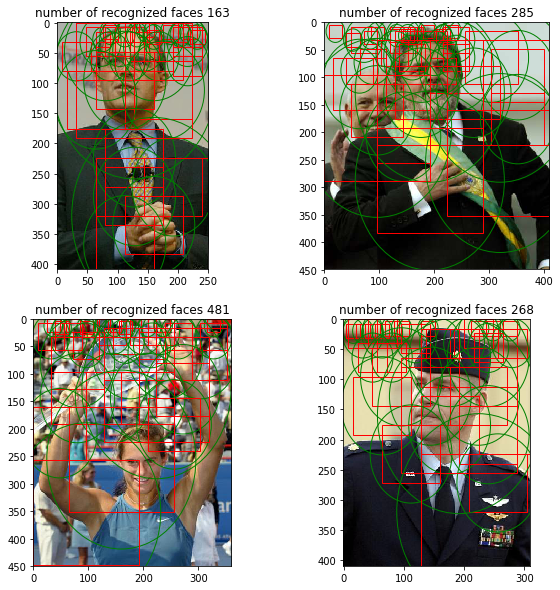

In [114]:
fig, axis = plt.subplots(2, 2, figsize=(10,10))
for ax, idx in zip(axis.flatten(), np.random.randint(0, len(imgs), 4)):
    drow_ff(imgs[idx], ax, 0.9, 0.25)

In [63]:
! rm fold-01-out.txt

In [64]:
with open('./fold-01-out.txt', 'w') as f:
    for t, path, img in zip(np.arange(len(imgs)), paths, imgs):
        f.write(extract_fddb_format(face_rec_12(img, 0.9, 0.2), path))
        f.write('\n')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27